## BCOM Momentum Timing Strategy Signals Creation and Comparison with AA Team Signals

### Setup

In [4]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

# Load BCOM data into pandas dataframes
close = pd.read_csv('BCOM_momentum_strategy_dailyclose.csv', index_col='Date', parse_dates=['Date'])
returns = pd.read_csv('BCOM_momentum_strategy_dailyreturns.csv', index_col='Date', parse_dates=['Date'])

# CHANGE MOVING AVERAGE WINDOW BELOW (IN DAYS)
#2M = 60
#3M = 90
#4M = 120
#6M = 180
#10M = 300
#16M = 480
MOVING_AVERAGE_WINDOW = 300
STARTING_BALANCE = 100
PERIODS = len(returns)
YEARS = PERIODS/365

In [5]:
# Calculate long BCOM periodic returns
returns['Long_Nominal_Returns'] = 1+returns.NominalReturn_BCOMTR

# Calculate short BCOM periodic returns
returns['Short_Nominal_Returns'] = 1+(-1*returns.NominalReturn_BCOMTR)

In [6]:
# BUY AND HOLD
# Calculate compounded annualized return
#BCOM_cagr = round((((returns['Long_Nominal_Returns'].product()) ** (365/PERIODS))-1) * 100, 2)

#returns['BCOM_Balance'] = STARTING_BALANCE * returns['Long_Nominal_Returns'].cumprod()

# Calculate drawdown
#returns['BCOM_Peak'] = returns.BCOM_Balance.cummax()
#returns['BCOM_DD'] = returns.BCOM_Balance - returns.BCOM_Peak
#BCOM_dd = round((((returns.BCOM_DD / returns.BCOM_Peak).min()) * 100), 2)

#print(f'BCOM CAGR: {BCOM_cagr}%')
#print(f'BCOM MAX DD: {BCOM_dd}%')

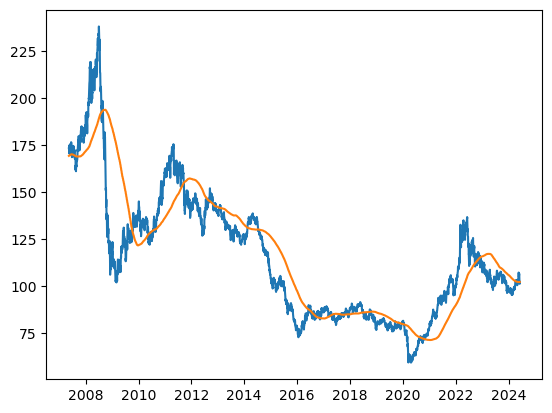

In [7]:
# Calculate moving average
close['SMA'] = close.Close.rolling(window = MOVING_AVERAGE_WINDOW).mean()
returns['Close'] = close ['Close']
returns['SMA'] = close ['SMA']

# Plot chart with moving average against BCOM
plt.plot(returns.Close)
plt.plot(returns.SMA)
plt.show()

# Create signals
returns['Buy'] = returns.Close > returns.SMA

### BCOM LONG-ONLY MOMENTUM STRATEGY 

In [9]:
# Calculate periodic return
# ADD DELAY BELOW by changing number in shift() parameter
returns['L_Strategy_Return'] = np.where(returns.Buy.shift(1) == True, returns['Long_Nominal_Returns'], 1)

# Calculate strategy balance
returns['L_Strategy_Balance'] = STARTING_BALANCE * returns.L_Strategy_Return.cumprod()

# Calculate compounded annualized return
L_strategy_cagr = round((((returns['L_Strategy_Return'].product()) ** (365/PERIODS))-1) * 100, 2)

# Calculate drawdown
returns['L_Strategy_Peak'] = returns.L_Strategy_Balance.cummax()
returns['L_Strategy_DD'] = returns.L_Strategy_Balance - returns.L_Strategy_Peak
L_strategy_dd = round((((returns.L_Strategy_DD / returns.L_Strategy_Peak).min()) * 100), 2)

# Generate signals
returns['L_momentum_signal'] = returns['Buy'].apply(lambda x: 1 if x else 0)

print(L_strategy_cagr)
print(L_strategy_dd)

0.83
-38.32


### BCOM LONG-SHORT MOMENTUM STRATEGY 

In [11]:
# Calculate periodic return
# ADD DELAY BELOW by changing number in shift() parameter
returns['LS_Strategy_Return'] = np.where(returns.Buy.shift(1) == True, returns['Long_Nominal_Returns'], returns['Short_Nominal_Returns'])

# Calculate strategy balance
returns['LS_Strategy_Balance'] = STARTING_BALANCE * returns.LS_Strategy_Return.cumprod()

# Calculate compounded annualized return
LS_strategy_cagr = round((((returns['LS_Strategy_Return'].product()) ** (365/PERIODS))-1) * 100, 2)

# Calculate drawdown
returns['LS_Strategy_Peak'] = returns.LS_Strategy_Balance.cummax()
returns['LS_Strategy_DD'] = returns.LS_Strategy_Balance - returns.LS_Strategy_Peak
LS_strategy_dd = round((((returns.LS_Strategy_DD / returns.LS_Strategy_Peak).min()) * 100), 2)

# Generate signals
returns['LS_momentum_signal'] = returns['Buy'].apply(lambda x: 1 if x else -1)

print(LS_strategy_cagr)
print(LS_strategy_dd)

3.86
-40.01


### BCOM Z-SCORE VOLATILITY ADJUSTMENT MOMENTUM STRATEGY

In [13]:
returns['log_Strategy_Returns'] = np.log(returns['L_Strategy_Return'])
returns['expanding_volatility'] = returns['log_Strategy_Returns'].expanding().std()
returns['momentum_z_score'] = (returns['Close']-returns['SMA'])/returns['expanding_volatility']

# Initialize columns for normalized Z-scores
returns['normalized_momentum_z_score'] = 0.0

# Iterate over the dataset to compute max and min up to each point
for i in range(len(returns)):
    current_data = returns.iloc[:i+1]
   
    pos_z_scores = current_data['momentum_z_score'][current_data['momentum_z_score'] > 0]
    neg_z_scores = current_data['momentum_z_score'][current_data['momentum_z_score'] < 0]
   
    # Normalize positive Z-scores to range 0 to 1
    if len(pos_z_scores) > 0:
        pos_z_scores_normalized = (pos_z_scores - pos_z_scores.min()) / (pos_z_scores.max() - pos_z_scores.min())
        returns.loc[pos_z_scores.index, 'normalized_momentum_z_score'] = pos_z_scores_normalized
   
    # Normalize negative Z-scores to range 0 to -1
    if len(neg_z_scores) > 0:
        neg_z_scores_normalized = (neg_z_scores - neg_z_scores.max()) / (neg_z_scores.min() - neg_z_scores.max())
        neg_z_scores_normalized = neg_z_scores_normalized * -1
        returns.loc[neg_z_scores.index, 'normalized_momentum_z_score'] = neg_z_scores_normalized


# Combine the normalized values into the original DataFrame
returns['normalized_momentum_z_score'] = returns['momentum_z_score']
returns.loc[pos_z_scores.index, 'normalized_momentum_z_score'] = pos_z_scores_normalized
returns.loc[neg_z_scores.index, 'normalized_momentum_z_score'] = neg_z_scores_normalized

# Calculate periodic returns
# Convert normalized values into absolute values
returns['absolute_normalized_momentum_z_score'] = returns['normalized_momentum_z_score'].abs()

# Calculate z-score long and short periodic returns
returns['Z_Long_Nominal_Returns'] = (((returns['Long_Nominal_Returns']-1) * 100 * returns['absolute_normalized_momentum_z_score'].shift(1))/100)+1
returns['Z_Short_Nominal_Returns'] = (((returns['Short_Nominal_Returns']-1) * 100 * returns['absolute_normalized_momentum_z_score'].shift(1))/100)+1

# ADD DELAY BELOW by changing number in shift() parameter
returns['Z_Strategy_Return'] = np.where(returns.normalized_momentum_z_score.shift(1) > 0, returns['Z_Long_Nominal_Returns'], returns['Z_Short_Nominal_Returns'])

# Calculate strategy balance
returns['Z_Strategy_Balance'] = STARTING_BALANCE * returns.Z_Strategy_Return.cumprod()

# Calculate compounded annualized return
Z_strategy_cagr = round((((returns['Z_Strategy_Return'].product()) ** (365/PERIODS))-1) * 100, 2)

# Calculate drawdown
returns['Z_Strategy_Peak'] = returns.Z_Strategy_Balance.cummax()
returns['Z_Strategy_DD'] = returns.Z_Strategy_Balance - returns.Z_Strategy_Peak
Z_strategy_dd = round((((returns.Z_Strategy_DD / returns.Z_Strategy_Peak).min()) * 100), 2)

print(Z_strategy_cagr)
print(Z_strategy_dd)

1.5
-21.95


### Tested Results

In [15]:
# Create excel file of results
file_name = 'generated_momentum_signals_dataframe.csv'
returns.to_csv(file_name, index=False)
print('DataFrame is written to CSV file successfully.')

DataFrame is written to CSV file successfully.


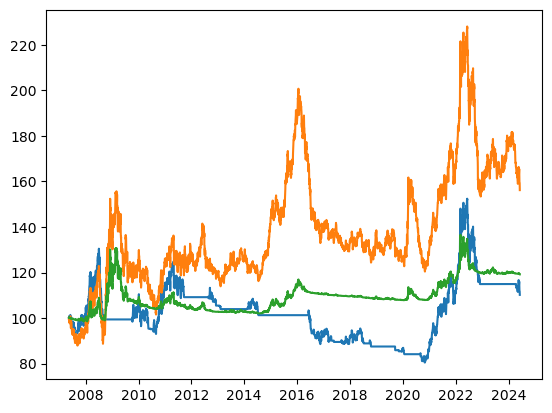

TESTED RESULTS:

LONG ONLY STRATEGY CAGR: 0.83%
LONG ONLY STRATEGY DD: -38.32%

LONG AND SHORT STRATEGY CAGR: 3.86%
LONG AND SHORT STRATEGY MAX DD: -40.01%

LONG AND SHORT Z SCORE STRATEGY CAGR: 1.5%
LONG AND SHORT Z SCORE STRATEGY MAX DD: -21.95%


In [16]:
# Total Returns vs. Timing Strategy Total Returns
plt.plot(returns.L_Strategy_Balance)
plt.plot(returns.LS_Strategy_Balance)
plt.plot(returns.Z_Strategy_Balance)
#plt.yscale("log")
#plt.plot(returns.BCOM_Balance.rolling(window=90).mean())
#plt.xlim([pd.to_datetime('2007-01-01'),pd.to_datetime('2010-01-01')])
#plt.ylim([700,900])
plt.xscale
plt.show()

print(f'TESTED RESULTS:')
print('')
print(f'LONG ONLY STRATEGY CAGR: {L_strategy_cagr}%')
print(f'LONG ONLY STRATEGY DD: {L_strategy_dd}%')
print('')
print(f'LONG AND SHORT STRATEGY CAGR: {LS_strategy_cagr}%')
print(f'LONG AND SHORT STRATEGY MAX DD: {LS_strategy_dd}%')
print('')
print(f'LONG AND SHORT Z SCORE STRATEGY CAGR: {Z_strategy_cagr}%')
print(f'LONG AND SHORT Z SCORE STRATEGY MAX DD: {Z_strategy_dd}%')

### Generate signals

In [18]:
import pandas as pd
import numpy as np
import datetime

signals = pd.read_csv('signals_template.csv', parse_dates=['Date1'])

# Generate L_ETR - min signal
signals['rolling_min'] = signals['L_ETR'].rolling(window=MOVING_AVERAGE_WINDOW).min()
signals['L_ETR - min'] = signals['L_ETR'] - signals['rolling_min']
signals.drop(columns=['rolling_min'], inplace=True)

# Generate L_ETR - SMA signal
signals['moving_average'] = signals['L_ETR'].rolling(window=MOVING_AVERAGE_WINDOW).mean()
signals['L_ETR - SMA'] = signals['L_ETR'] - signals['moving_average']
signals.drop(columns=['moving_average'], inplace=True)

# Collect Momentum signals
momentum_signals = pd.read_csv('generated_momentum_signals_dataframe.csv')
signals['L_momentum_signal'] = momentum_signals['L_momentum_signal']
signals['LS_momentum_signal'] = momentum_signals['LS_momentum_signal']
signals['LS_momentum_Z_signal'] = momentum_signals['normalized_momentum_z_score']

# Generate excel sheet with all signals
file_name = 'signals_all.xlsx'
signals.to_excel(file_name, index=False)
print('All Signals DataFrame is written to Excel file successfully.')

# Merge signals
df = pd.read_excel('signals_all.xlsx')

# Convert Date 1 and Date 2 columns to datetime
df['Date1'] = pd.to_datetime(df['Date1'], errors = 'coerce')
df['Date2'] = pd.to_datetime(df['Date2'], errors = 'coerce')

# Combine the dataframes by merging on dates
combined_df = pd.merge(df[['Date1'] + list(df.columns[1:7])],
                       df[['Date2'] + list(df.columns[8:11])],
                       left_on='Date1', right_on='Date2', how='outer')

# Drop the duplicate date columns and rename the merged date column
combined_df = combined_df.drop(columns=['Date2'])
combined_df = combined_df.rename(columns={'Date1': 'Date'})

# Sort by date
combined_df = combined_df.sort_values(by='Date')

# Forward fill missing values
forward_filled_df = combined_df.ffill()

# Save the results to CSV file
file_name = 'forward_fill_withdate.csv'
forward_filled_df.to_csv(file_name, index=False)
print('Forward Filled With Date DataFrame is written to CSV file successfully.')

forward_filled_df_nodate = forward_filled_df.drop(columns=['Date'])

file_name = 'forward_fill_nodate.csv'
forward_filled_df_nodate.to_csv(file_name, index=False)
print('Forward Filled With No Date DataFrame is written to CSV file successfully.')

All Signals DataFrame is written to Excel file successfully.
Forward Filled With Date DataFrame is written to CSV file successfully.
Forward Filled With No Date DataFrame is written to CSV file successfully.


### Full period Correlation matrix

<Axes: >

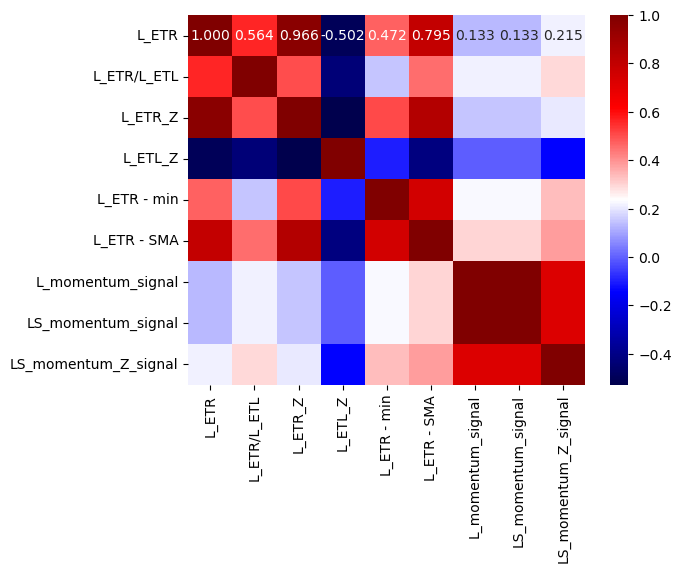

In [56]:
import seaborn as sns 
from sklearn import datasets  

returnscomparison = pd.read_csv('forward_fill_nodate.csv')
matrix = returnscomparison.corr()

# Plotting the correlation matrix 
sns.heatmap(matrix, cmap="seismic", annot=True, fmt='.3f')

### Rolling Correlation Matrix (SAME ROLLING WINDOW AS MOMENTUM STRATEGY)

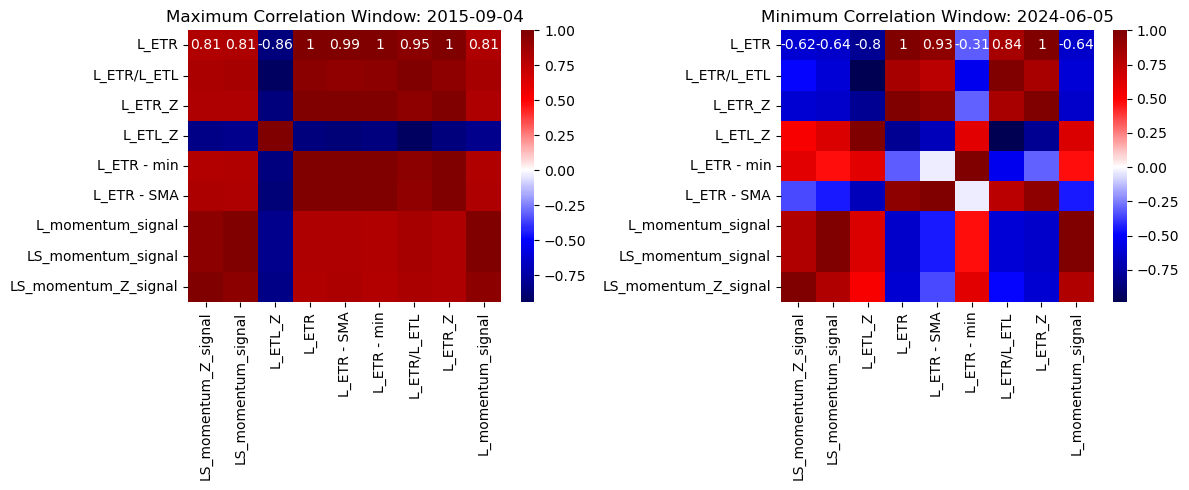

In [22]:
import seaborn as sns 
from sklearn import datasets

# Calculating the rolling correlation matrix with a 90-day window
returnscomparison = pd.read_csv('forward_fill_withdate.csv')

# Parse dates
returnscomparison['Date'] = pd.to_datetime(returnscomparison['Date'])

# Ensure the DataFrame is sorted by Date
returnscomparison = returnscomparison.sort_values('Date')

# Drop rows with NaN values
returnscomparison = returnscomparison.dropna()

# Select only numeric columns for correlation
numeric_cols = returnscomparison.select_dtypes(include=[np.number])

# Calculate rolling correlations
rolling_corrs = numeric_cols.rolling(window=MOVING_AVERAGE_WINDOW).corr().unstack().dropna()

# Group by the level to get the mean correlation of each window
mean_corrs = rolling_corrs.groupby(level=0).mean()

# Find the windows with the highest and lowest mean correlation
max_corr_window = mean_corrs.mean(axis=1).idxmax()
min_corr_window = mean_corrs.mean(axis=1).idxmin()

# Extract the correlation matrices for these windows
max_corr_returnscomparison = rolling_corrs.loc[max_corr_window]
min_corr_returnscomparison = rolling_corrs.loc[min_corr_window]

# Convert them to proper DataFrame formats
max_corr_returnscomparison = max_corr_returnscomparison.unstack()
min_corr_returnscomparison = min_corr_returnscomparison.unstack()

# Get the corresponding dates
max_corr_date = returnscomparison.iloc[max_corr_window].Date
min_corr_date = returnscomparison.iloc[min_corr_window].Date

# Plotting heatmaps for the maximum and minimum correlation windows
plt.figure(figsize=(12, 5))

# Heatmap for the maximum correlation window
plt.subplot(1, 2, 1)
sns.heatmap(max_corr_returnscomparison, annot=True, cmap='seismic', center=0)
plt.title(f'Maximum Correlation Window: {max_corr_date.date()}')

# Heatmap for the minimum correlation window
plt.subplot(1, 2, 2)
sns.heatmap(min_corr_returnscomparison, annot=True, cmap='seismic', center=0)
plt.title(f'Minimum Correlation Window: {min_corr_date.date()}')

plt.tight_layout()
plt.show()

### Regression to predict future returns

Forward Filled Regression DataFrame is written to CSV file successfully.


C:\Users\dinga\AppData\Local\Temp\ipykernel_16208\2369220740.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results_single.append((var, model.params[1], model.tvalues[1], R, R_squared, model))
C:\Users\dinga\AppData\Local\Temp\ipykernel_16208\2369220740.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results_single.append((var, model.params[1], model.tvalues[1], R, R_squared, model))
C:\Users\dinga\AppData\Local\Temp\ipykernel_16208\2369220740.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent wit

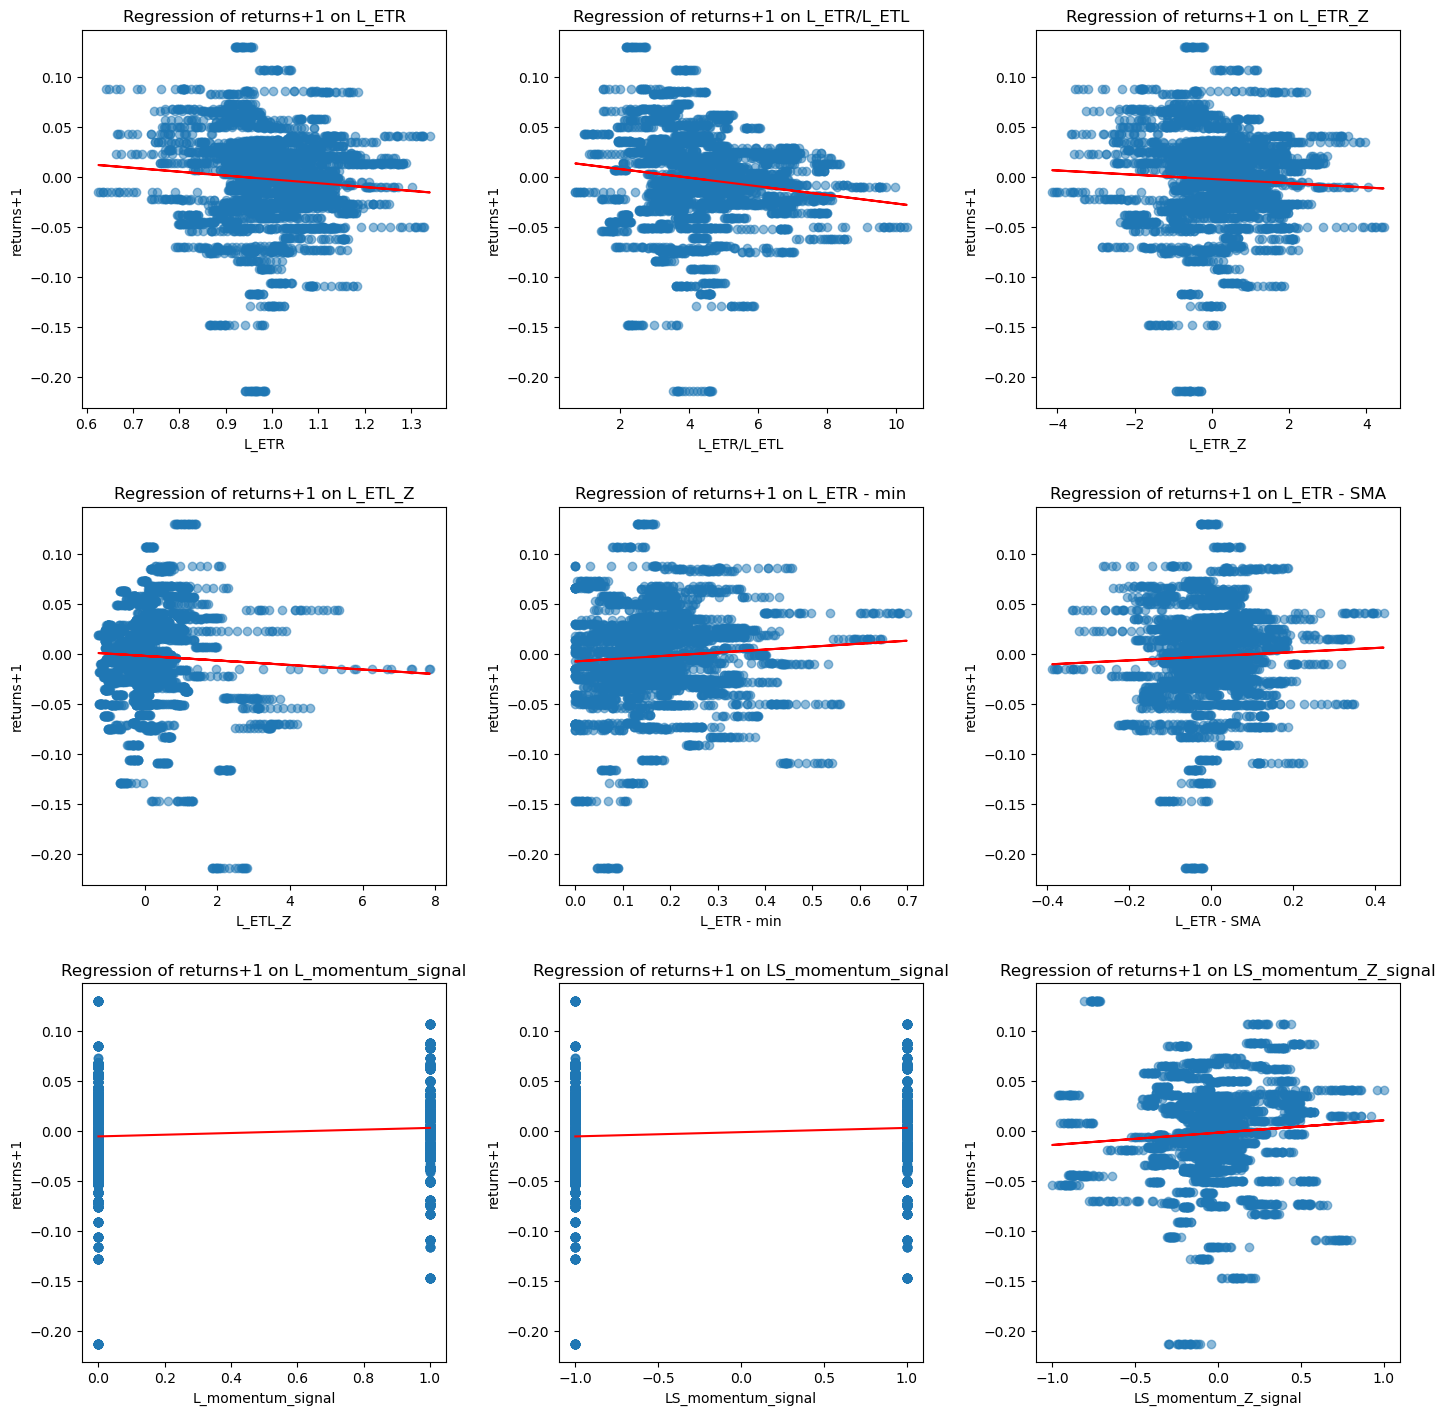

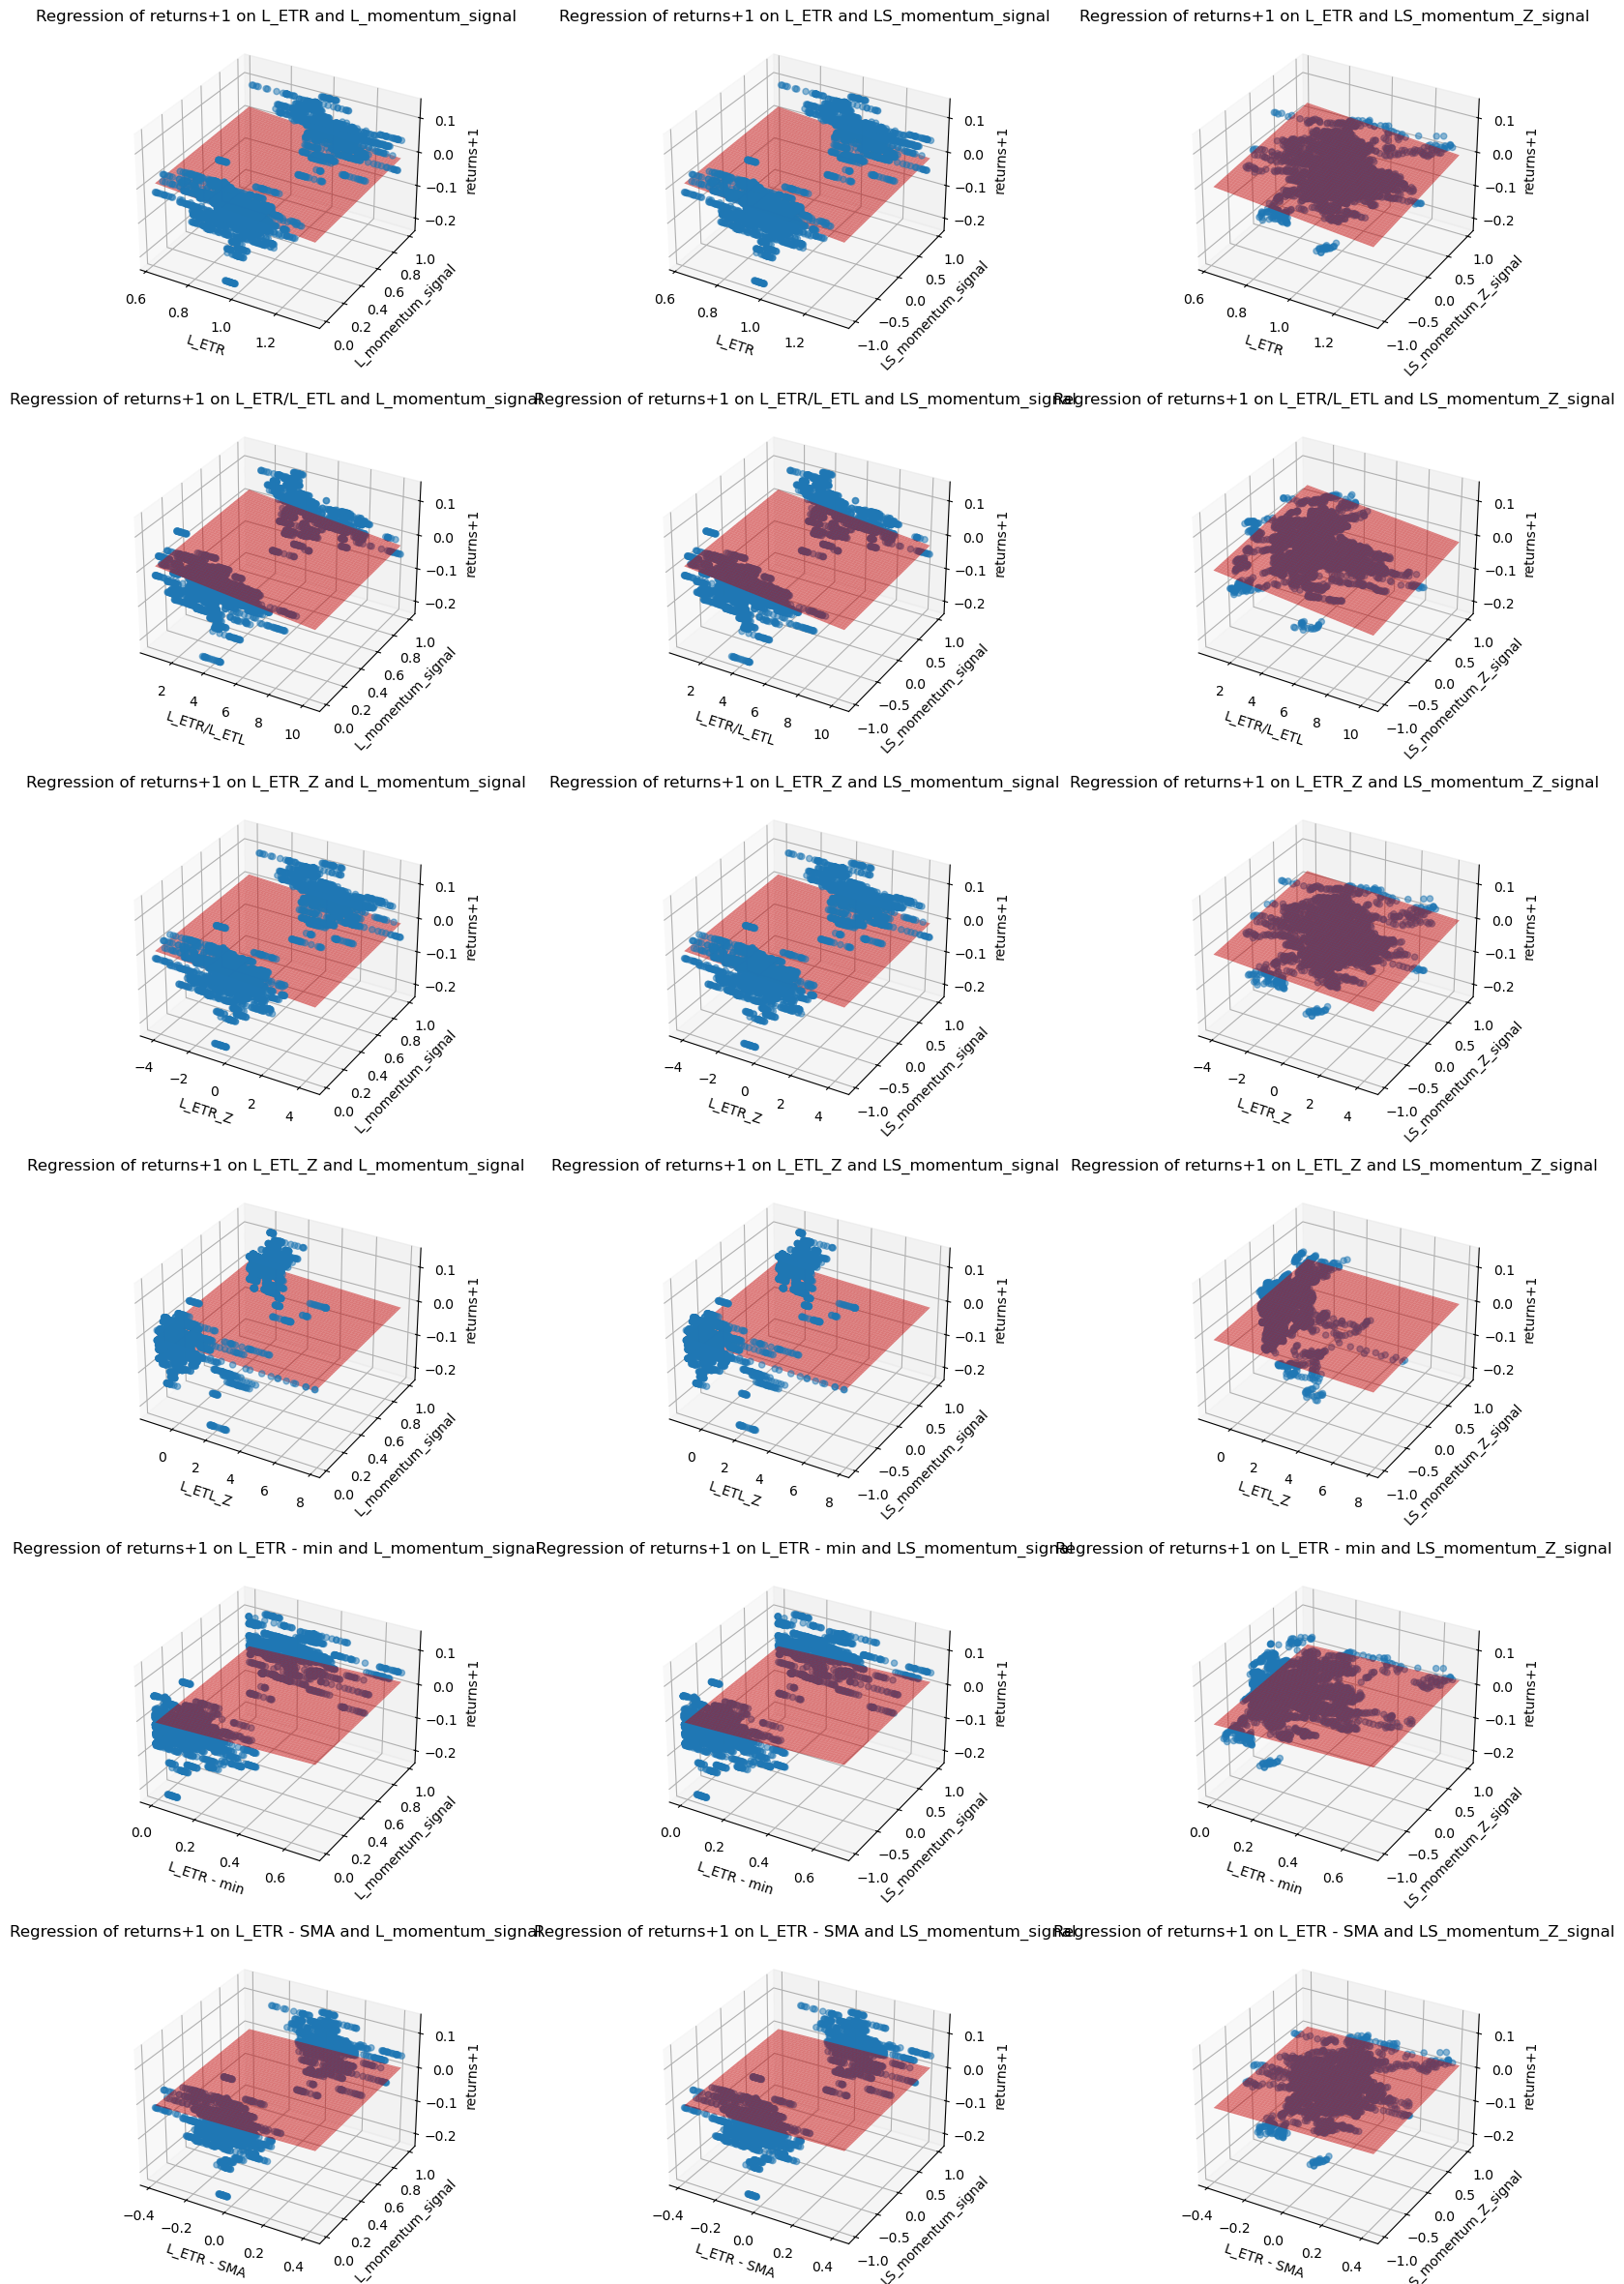

Single Variable Regressions
+----------------------+------------------------+---------------------+----------------------+-----------------------+
|       Variable       |          Beta          |        T-test       |          R           |           R²          |
+----------------------+------------------------+---------------------+----------------------+-----------------------+
|        L_ETR         | -0.038238403633808676  |  -5.557553480885231 | -0.08620884304738959 |  0.007431964619569451 |
|     L_ETR/L_ETL      | -0.0043060841067770975 |  -9.25352017390837  | -0.14260460757238366 |  0.020336074100873545 |
|       L_ETR_Z        | -0.002124355880024075  | -3.5123638136382653 | -0.05460583612153265 |  0.00298179733853168  |
|       L_ETL_Z        | -0.002260984900901598  | -3.0944366289474927 | -0.04812448863451056 | 0.0023159664063331364 |
|     L_ETR - min      |  0.02948699371586763   |  4.573281766829627  |  0.0710260671662355  |  0.005044702217102596 |
|     L_ETR - SMA   

In [24]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from prettytable import PrettyTable

# Load CSV files into pandas dataframes
forward_fill_regression_df = pd.read_csv('forward_fill_withdate.csv')
regression_nextmonthreturns_df = pd.read_csv('regression_nextmonthreturns.csv')

# Step 1: Convert the Date column to datetime format
forward_fill_regression_df['Date'] = pd.to_datetime(forward_fill_regression_df['Date'])

# Step 2: Extract the year and month and create a new column for matching
forward_fill_regression_df['YearMonth'] = forward_fill_regression_df['Date'].dt.strftime('%Y-%m')

# Step 3: Merge the dataframes on the YearMonth column
merged_df = forward_fill_regression_df.merge(regression_nextmonthreturns_df, on='YearMonth', how='left')

# Step 4: Add the returns+1 column to forward_fill_regression_df
forward_fill_regression_df['returns+1'] = merged_df['returns+1']

# Drop YearMonth column
forward_fill_regression_df = forward_fill_regression_df.drop(columns=['YearMonth'])

# Save the forward-filled regression dataframe to CSV
file_name = 'forward_fill_regression.csv'
forward_fill_regression_df.to_csv(file_name, index=False)
print('Forward Filled Regression DataFrame is written to CSV file successfully.')

# Reload the saved CSV file
data = pd.read_csv('forward_fill_regression.csv')

# Replace infinite values with NaNs and then drop rows with NaNs
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

# Define the dependent variable
dependent_var = 'returns+1'

# Define the independent variables
independent_vars_single = ['L_ETR', 'L_ETR/L_ETL', 'L_ETR_Z', 'L_ETL_Z', 'L_ETR - min', 'L_ETR - SMA', 'L_momentum_signal', 'LS_momentum_signal', 'LS_momentum_Z_signal']

independent_vars_pairs = [
    ('L_ETR', 'L_momentum_signal'),
    ('L_ETR', 'LS_momentum_signal'),
    ('L_ETR', 'LS_momentum_Z_signal'),
    ('L_ETR/L_ETL', 'L_momentum_signal'),
    ('L_ETR/L_ETL', 'LS_momentum_signal'),
    ('L_ETR/L_ETL', 'LS_momentum_Z_signal'),
    ('L_ETR_Z', 'L_momentum_signal'),
    ('L_ETR_Z', 'LS_momentum_signal'),
    ('L_ETR_Z', 'LS_momentum_Z_signal'),
    ('L_ETL_Z', 'L_momentum_signal'),
    ('L_ETL_Z', 'LS_momentum_signal'),
    ('L_ETL_Z', 'LS_momentum_Z_signal'),
    ('L_ETR - min', 'L_momentum_signal'),
    ('L_ETR - min', 'LS_momentum_signal'),
    ('L_ETR - min', 'LS_momentum_Z_signal'),
    ('L_ETR - SMA', 'L_momentum_signal'),
    ('L_ETR - SMA', 'LS_momentum_signal'),
    ('L_ETR - SMA', 'LS_momentum_Z_signal')
]

# Perform the regressions and store the results
results_single = []
results_pairs = []

for var in independent_vars_single:
    X = sm.add_constant(data[var])
    model = sm.OLS(data[dependent_var], X).fit()
    R = np.corrcoef(data[var], data[dependent_var])[0, 1]
    R_squared = R ** 2
    results_single.append((var, model.params[1], model.tvalues[1], R, R_squared, model))

for var1, var2 in independent_vars_pairs:
    X = sm.add_constant(data[[var1, var2]])
    model = sm.OLS(data[dependent_var], X).fit()
    R = np.corrcoef(model.fittedvalues, data[dependent_var])[0, 1]
    R_squared = R ** 2
    results_pairs.append(((var1, var2), model.params[1:], model.tvalues[1:], R, R_squared, model))

# Create tables for betas, t-tests, R, and R²
table_single = pd.DataFrame(results_single, columns=['Variable', 'Beta', 'T-test', 'R', 'R²', 'Model'])
table_pairs = pd.DataFrame(results_pairs, columns=['Variables', 'Betas', 'T-tests', 'R', 'R²', 'Model'])

# Plotting single variable regressions
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
fig.tight_layout(pad=5.0)
for i, (var, _, _, _, _, model) in enumerate(results_single):
    ax = axs[i // 3, i % 3]
    ax.scatter(data[var], data[dependent_var], alpha=0.5)
    ax.plot(data[var], model.predict(), color='red')
    ax.set_title(f'Regression of {dependent_var} on {var}')
    ax.set_xlabel(var)
    ax.set_ylabel(dependent_var)

# Plotting pair variable regressions
fig = plt.figure(figsize=(20, 30))
for i, ((var1, var2), _, _, _, _, model) in enumerate(results_pairs):
    ax = fig.add_subplot(6, 3, i + 1, projection='3d')
    ax.scatter(data[var1], data[var2], data[dependent_var], alpha=0.5)
    x_surf, y_surf = np.meshgrid(np.linspace(data[var1].min(), data[var1].max(), 100),
                                 np.linspace(data[var2].min(), data[var2].max(), 100))
    z_surf = model.params[0] + model.params[1] * x_surf + model.params[2] * y_surf
    ax.plot_surface(x_surf, y_surf, z_surf, color='red', alpha=0.5)
    ax.set_title(f'Regression of {dependent_var} on {var1} and {var2}')
    ax.set_xlabel(var1)
    ax.set_ylabel(var2)
    ax.set_zlabel(dependent_var)

plt.show()

# Display tables in a presentable format using PrettyTable
def display_pretty_table(df, title):
    table = PrettyTable()
    table.field_names = df.columns.tolist()
    for _, row in df.iterrows():
        table.add_row(row.tolist())
    print(title)
    print(table)

display_pretty_table(table_single[['Variable', 'Beta', 'T-test', 'R', 'R²']], "Single Variable Regressions")
display_pretty_table(table_pairs[['Variables', 'Betas', 'T-tests', 'R', 'R²']], "Pair Variable Regressions")